# Topic Model Research Notebook

The following notebook is designed to give a user a notebook environment to train lda models, view results, and further
optimize parameters based on the data being trained.

Users will be able to:
- Select Data from a given directory.
- Set parameters for LDA model to be trained.
- View coherence plots.
- View pyLDAvis of topics for entire corpora.
- View Topic Interpretability Table for entire corpora.
- Set parameter for recommender systems*
- View results of recommender system.
- View recommender system visuals.
- View brief description(s) on algorithms and parameters used for models.

[*] To be decided


In [62]:
# Import libraries
import os
from tkinter import *
from tkinter import filedialog
import ipywidgets as widgets
from IPython.display import display
import io
import pandas as pd
import json
from cleantext import *
from stopwordslist import *
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim

%matplotlib inline

## Set Up Data Directory

Locate the 'config.ini' file and set the directory for your files.

In [4]:
# Set directory where files can be accessed.
os.chdir('../../data/reviews')

In [5]:
# Display list of files in SelectMultiple format
files_to_use = widgets.SelectMultiple(
    options=os.listdir(),
    # value=['Files'],
    # rows=10
    description='Files',
    disabled=False
)

In [8]:
display(files_to_use)

SelectMultiple(description='Files', options=('meta_Prime_Pantry.json', 'meta_Prime_Pantry_Copy.json'), value=(…

In [9]:
files_to_use.value

('meta_Prime_Pantry.json',)

In [10]:
# Load Data
data = []
for line in open(files_to_use.value[0], 'r'):
    data.append(json.loads(line))


In [11]:
df = pd.DataFrame(data)

df.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",[https://images-na.ssl-images-amazon.com/image...,,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO
1,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",[https://images-na.ssl-images-amazon.com/image...,,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO
2,[],,[A perfect Lentil soup starts with Goya Lentil...,,"Goya Dry Lentils, 16 oz","[B003SI144W, B000VDRKEK]",[https://images-na.ssl-images-amazon.com/image...,,Goya,[],[],"[B074MFVZG7, B079PTH69L, B000VDRKEK, B074M9T81...",{'ASIN: ': 'B0000DIF38'},"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIF38
3,[],,[Saran Premium Wrap is an extra tough yet easy...,,"Saran Premium Plastic Wrap, 100 Sq Ft","[B01MY5FHT6, B000PYF8VM, B000SRMDFA, B07CX6LN8...",[https://images-na.ssl-images-amazon.com/image...,,Saran,[],[],"[B077QLSLRQ, B00JPKW1RQ, B000FE2IK6, B00XUJHJ9...",{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIWNI
4,[],,[200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...,,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",[],[https://images-na.ssl-images-amazon.com/image...,,Saran,[],[],[B0014CZ0TE],{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIWNZ


In [12]:
# Extract only review text and sample 1000
reviews = pd.DataFrame(df.description).sample(5000)
reviews = reviews.applymap(lambda x: x if not isinstance(x, list) else x[0] if len(x) else '')

In [13]:
# Set directory where files can be accessed.
os.chdir('../../topicmodel')

In [14]:
# Clean reviews
clean_reviews = clean_all(reviews, 'description')

clean_reviews.head()

,description
6963,b keep your style fresh without the hassle of ...
4794,b sometimes you ve get to pull out the big gun...
1906,b wild planet be commit to provide the fine ta...
3866,b covergirl clump crusher water resistant masc...
4145,b campbells condense healthy request bean with...


## Form Bigrams and Trigrams

### Compute PMI Scores

In [15]:
def compute_bigram_pmi(word_frequency=50):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split()
                                                                   for comment in clean_reviews.description])
    # Filter only those that occur at least 50 times
    finder.apply_freq_filter(word_frequency)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)
    
    # Calculate pmi scores
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

    return bigram_pmi

def compute_trigram_pmi(word_frequency=50):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split()
                                                                    for comment in clean_reviews.description])
    # Filter only those that occur at least 50 times
    finder.apply_freq_filter(word_frequency)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)
    
    # Calculate pmi scores
    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    
    return trigram_pmi

In [16]:
# Compute pmi scores
bigram_pmi = compute_bigram_pmi()

trigram_pmi = compute_trigram_pmi()

In [17]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True


In [18]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

### Set PMI Threshold Value

In [19]:
# PMI threshold can be set to any value which makes sense - eyeball through and select threshold where n-grams stop
# making sense. Choose top 500 ngrams, in this case, ranked by PMI that have noun like structures.
def set_bigram_pmi_threshold(pmi_threshold=5):
    filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                                  bigram_filter(bigram['bigram'])\
                                                  and bigram.pmi > pmi_threshold, axis = 1)][:500]
    bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

    return bigrams

def set_trigram_pmi_threshold(pmi_threshold=5):
    filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > pmi_threshold, axis = 1)][:500]


    trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

    return trigrams

In [20]:
bigrams = set_bigram_pmi_threshold()

trigrams = set_trigram_pmi_threshold()

In [21]:
# Bigram Sample
bigrams[:10]

['duncan hine',
 'united state',
 'project verify',
 'drug administration',
 'individually wrap',
 'fructose corn',
 'gmo project',
 'fatty acid',
 'amino acid',
 'sea salt']

In [22]:
# Trigram Sample
trigrams[:10]

['gmo project verify',
 'fructose corn syrup',
 'diagnose treat cure',
 'non gmo project',
 'high fructose corn',
 'wellness complete health',
 'dry cat food',
 'dry dog food',
 'food grain free']

In [23]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

### Output Comments W NGrams

In [24]:
def output_comments_w_ngrams():
    
    comments_w_ngrams = clean_reviews.copy()
    
    comments_w_ngrams.description = comments_w_ngrams.description.map(lambda x: replace_ngram(x))
    
    # Tokenize comments + remove stop words + remove words with less than 2 characters
    comments_w_ngrams = comments_w_ngrams.description.map(lambda x: [word for word in x.split()\
                                                                     if word not in stop_word_list\
                                                                     and word not in english_names\
                                                                     and len(word) > 2])
    return comments_w_ngrams

In [25]:
comments_w_ngrams = output_comments_w_ngrams()

In [26]:
comments_w_ngrams.head()

6963    [style, fresh, hassle, cleanup, remington, vac...
4794    [pull, big, gun, seventh, generation, ultra, p...
1906    [wild, planet, commit, provide, fine, tasting,...
3866    [covergirl, clump, crusher, water, resistant, ...
4145    [campbells, condense, healthy, request, bean, ...
Name: description, dtype: object

## Filter for only nouns

Filtering for nouns cleans the text for words that are more interpretable in the topic model.

In [27]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [29]:
#%%

final_comments = comments_w_ngrams.map(noun_only)

# LDA Model

## Optimize for k topics

To improve human interpretability, let's focus on the enchancement of the Cv measures as indicated
[here](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). This measure assess the interpretability of
topics given the set of words in the generated topics.

If the same words start appearing across multiple topics, the number of topics is too high.


In [56]:
def output_coherence_model(final_comments, starting_topic_num, ending_topic_num,
                     lda_passes, lda_iterations, lda_chunksize):
    # Initialize corpora dictionary of comments
    comment_dictionary = corpora.Dictionary(final_comments)
    
    # Initialize document-term-matrix
    doc_term_matrix = [comment_dictionary.doc2bow(doc) for doc in final_comments]
    
    # Optimize for k topics
    # Initialize cohere value list
    coherence = []
    # Obtainn Coherence Models by training multiple LDA models with different topic values and parameters. 
    for k in range(starting_topic_num, ending_topic_num):
        print('LDA Training - Number of Topics: ' + str(k))
        lda = gensim.models.ldamodel.LdaModel
        lda_model = lda(doc_term_matrix, num_topics=k, id2word=comment_dictionary, passes=lda_passes,
                       iterations=lda_iterations, chunksize=lda_chunksize, eval_every=None)
        
        coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=final_comments,
                                                        dictionary=comment_dictionary, coherence='c_v')
        
        coherence.append((k, coherence_model.get_coherence()))
    
    # Intialize x and y values for coherenence model evaluations
    x_val = [x[0] for x in coherence]
    y_val = [x[1] for x in coherence]
    
    # Plot coherence model results to determine the best number of topics using 
    # the given parameters. 
    plt.plot(x_val,y_val)
    plt.scatter(x_val,y_val)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.xticks(x_val)
    plt.show()
    
    return comment_dictionary, doc_term_matrix

LDA Training - Number of Topics: 5
LDA Training - Number of Topics: 6
LDA Training - Number of Topics: 7
LDA Training - Number of Topics: 8
LDA Training - Number of Topics: 9
LDA Training - Number of Topics: 10
LDA Training - Number of Topics: 11
LDA Training - Number of Topics: 12
LDA Training - Number of Topics: 13
LDA Training - Number of Topics: 14
LDA Training - Number of Topics: 15
LDA Training - Number of Topics: 16
LDA Training - Number of Topics: 17
LDA Training - Number of Topics: 18
LDA Training - Number of Topics: 19
LDA Training - Number of Topics: 20
LDA Training - Number of Topics: 21
LDA Training - Number of Topics: 22
LDA Training - Number of Topics: 23
LDA Training - Number of Topics: 24
LDA Training - Number of Topics: 25


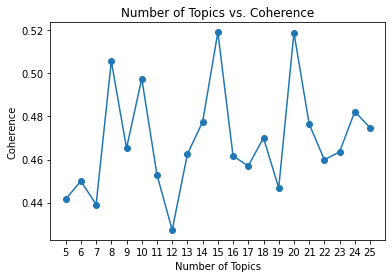

In [57]:
comment_dict, full_dtm = output_coherence_model(final_comments, 5, 26, 40, 200, 1000)

## Output Best LDA Model(s)

In [58]:
def output_best_lda_model(full_dtm, best_num_topics, num_words_per_topic, comment_dictionary, best_num_lda_passes,
                          best_num_lda_iterations, best_num_lda_chunksize, random_state_value=0):
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(full_dtm, num_topics=best_num_topics, id2word = comment_dictionary, passes=best_num_lda_passes,\
                   iterations=best_num_lda_iterations,  chunksize = best_num_lda_chunksize, eval_every = None, random_state=random_state_value)
    
    lda_model.show_topics(best_num_topics, num_words=num_words_per_topic, formatted=False)
    
    return lda_model

In [59]:
best_lda_model = output_best_lda_model(full_dtm, 11, 10, comment_dict, 40, 200, 1000)

## Relevancy - Topic Modeling Visualiztion

In [63]:
topic_data =  pyLDAvis.gensim.prepare(best_lda_model, full_dtm, comment_dict, mds = 'pcoa')
pyLDAvis.display(topic_data)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Extract Word List for each Topic Using a Predefined Lambda

In [66]:
def output_word_list(_lambda):
    # To extract words for a given lambda.
    all_topics = {}
    num_terms = 10 # Adjust number of words to represent each topic
    # _lambda = 0.08 # Adjust this accordingly based on tuning above
    for i in range(1,9): #Adjust this to reflect number of topics chosen for final LDA model
        topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
        topic['relevance'] = topic['loglift']*(1-_lambda)+topic['logprob']*_lambda
        all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

    topics_df = pd.DataFrame(all_topics).T
    return topics_df

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
output_word_list(.08)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
Topic 1,hair,skin,conditioner,shampoo,lip,shine,lotion,makeup,moisturizer,damage
Topic 2,snack,chocolate,bar,chip,crunch,peanut_butter,cheddar,dip,potato_chip,iced_tea
Topic 3,calcium,fever,intend,statement,vitamin_d,supplement,diagnose_treat_cure,magnesium,hershey,brain
Topic 4,boiron,knorr,commit,tender,peppermint,stomach,battery,cavity,crocker,bathroom
Topic 5,coffee,eye,lash,curl,toothpaste,mascara,chili,foot,dandruff,shoulder
Topic 6,detergent,relief,sheet,ache,symptom,cough,throat,pain,laundry,headache
Topic 7,dog,cat,cat_food,dog_food,wellness,bandage,wellness_complete_health,gum,dry_cat_food,grain_free
Topic 8,cereal,almond,breakfast,grain,barilla,quaker,granola,oat,bread,chunk


## Inspecting Topics

In [69]:
def inspect_topics(lda_model):
    for topic_id in range(lda_model.num_topics):
        topk = lda_model.show_topic(topic_id, 8)
        topk_words = [ w for w, _ in topk ]

        print('{}: {}'.format(topic_id, ' '.join(topk_words)))

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
inspect_topics(best_lda_model)

0: rice family product food ingredient soup year company
1: coffee eye use product cup water bean chili
2: grain food cereal almond wheat breakfast pasta help
3: protein food product health help support calcium body
4: relief pain use product stain symptom detergent water
5: protection design help comfort support size pad fit
6: dog cat cat_food health food ingredient dog_food wellness
7: cracker heat beef style stick work thing feature
8: flavor snack taste bar fruit chocolate pack chip
9: tea day image protection odor mint body_wash deodorant
10: hair skin use help oil formula conditioner color


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Predict the topics of a Document

Results here will continuously vary due to random number generation of the algorithm.
This method can be used a means to determine how well a topic relates to a comment.


In [73]:
# Example
def predict_topics(document, lda_model):
    doc = document.split()

    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    
    print(doc_topics)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
predict_topics('this book describes windows software', best_lda_model)

[(0, 0.03031991), (1, 0.03031991), (2, 0.3635675), (3, 0.03031991), (4, 0.03031991), (5, 0.03031991), (6, 0.03031991), (7, 0.03031991), (8, 0.03031991), (9, 0.36355335), (10, 0.03031991)]


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Recommending a topic based on word association weights.

A recommender system could be used to potentially determine the exact predefined topic for a word.

### Train Multiple Coherence Models with a list of numerous parameters

In [ ]:
# Set Dictionary with list of various parameter values
lda_training_dictionary = {'lda_passes' : [],
                          'lda_iterations': [],
                          'lda_chunksize': []}

#### User Interface - Coherence Model Training